In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
import copy

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [7]:
csv = 'study_performance.csv'
my_df = pd.read_csv(csv, index_col=0)
my_df.head()
my_df.dropna(inplace=True)
my_df.reset_index(drop=True, inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   race_ethnicity               1000 non-null   object
 1   parental_level_of_education  1000 non-null   object
 2   lunch                        1000 non-null   object
 3   test_preparation_course      1000 non-null   object
 4   math_score                   1000 non-null   int64 
 5   reading_score                1000 non-null   int64 
 6   writing_score                1000 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 54.8+ KB


In [88]:
# Calculate the mean of the math_score column
math_score_mean = my_df['math_score'].mean()

# Create a new column 'math_score_cat' based on the condition
math_score_cat = np.where(my_df['math_score'] > math_score_mean, 'high', 'low')

# Create a new DataFrame 'training_df' with the desired columns and the new column
training_df = pd.DataFrame({
    'race_ethnicity': my_df['race_ethnicity'],
    'parental_level_of_education': my_df['parental_level_of_education'],
    'lunch': my_df['lunch'],
    'test_preparation_course': my_df['test_preparation_course'],
    'writing_score': my_df['writing_score'],
    'math_score_cat': math_score_cat
})

training_df['math_score_cat'] = training_df['math_score_cat'].astype('category')

training_df

,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,writing_score,math_score_cat
0,group B,bachelor's degree,standard,none,74,high
1,group C,some college,standard,completed,88,high
2,group B,master's degree,standard,none,93,high
3,group A,associate's degree,free/reduced,none,44,low
4,group C,some college,standard,none,75,high
...,...,...,...,...,...,...
995,group E,master's degree,standard,completed,95,high
996,group C,high school,free/reduced,none,55,low
997,group C,high school,free/reduced,completed,65,low
998,group D,some college,standard,completed,77,high


Step 1: Checking CUDA availability
CUDA is available! Using GPU

Step 2: Data preprocessing
Detecting categorical columns...
Column: race_ethnicity, Data Type: object
Column: parental_level_of_education, Data Type: object
Column: lunch, Data Type: object
Column: test_preparation_course, Data Type: object
Column: writing_score, Data Type: int64
Column: math_score_cat, Data Type: int32
Detected categorical columns: ['race_ethnicity', 'parental_level_of_education', 'lunch', 'test_preparation_course']

Step 3: Model training
Early stopping at epoch 36 with F1 score: 0.7111
Best F1: 0.7111


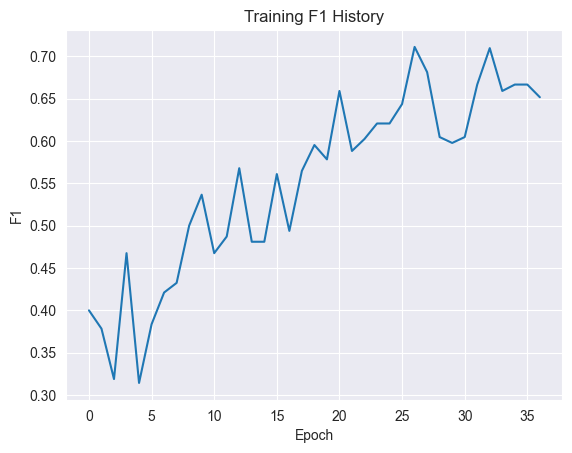


Step 4: Prediction
Upscaling binary categories to probabilities...
Disclaimer: If F1 score is low, data may not contain sufficient information to create accurate binary-to-probability upscaling.

Step 5: Creating results DataFrame
Labeling predictions...

Step 6: Concatenating results with original data
Creating output data frame...


In [106]:
import importlib
import reverse_binary

importlib.reload(reverse_binary)
from reverse_binary import convert_binary_to_probability

output_df = convert_binary_to_probability(
    data=training_df,
    target_column='math_score_cat',
    train_size=.9,
    n_epochs=500,
    batch_size=64,
    threshold=0.5,
    positive_label='high'  # Specify the label to be encoded as 1
)

In [107]:
output_df

,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,writing_score,math_score_cat,math_score_cat_rbprob,math_score_cat_rblab
0,group B,bachelor's degree,standard,none,74,high,0.490159,0
1,group C,some college,standard,completed,88,high,0.612639,1
2,group B,master's degree,standard,none,93,high,0.696649,1
3,group A,associate's degree,free/reduced,none,44,low,0.229433,0
4,group C,some college,standard,none,75,high,0.506250,1
...,...,...,...,...,...,...,...,...
995,group E,master's degree,standard,completed,95,high,0.665293,1
996,group C,high school,free/reduced,none,55,low,0.287337,0
997,group C,high school,free/reduced,completed,65,low,0.408737,0
998,group D,some college,standard,completed,77,high,0.502247,1


In [108]:
import pandas as pd

# Assuming you have two DataFrames: my_df and output_df
common_cols = list(set(my_df.columns) & set(output_df.columns))

merged_df = pd.concat([my_df, output_df.drop(columns=common_cols, inplace=False)], axis=1)

In [109]:
merged_df

,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score,math_score_cat,math_score_cat_rbprob,math_score_cat_rblab
0,group B,bachelor's degree,standard,none,72,72,74,high,0.490159,0
1,group C,some college,standard,completed,69,90,88,high,0.612639,1
2,group B,master's degree,standard,none,90,95,93,high,0.696649,1
3,group A,associate's degree,free/reduced,none,47,57,44,low,0.229433,0
4,group C,some college,standard,none,76,78,75,high,0.506250,1
...,...,...,...,...,...,...,...,...,...,...
995,group E,master's degree,standard,completed,88,99,95,high,0.665293,1
996,group C,high school,free/reduced,none,62,55,55,low,0.287337,0
997,group C,high school,free/reduced,completed,59,71,65,low,0.408737,0
998,group D,some college,standard,completed,68,78,77,high,0.502247,1


In [110]:
# Create a copy to avoid modifying the original DataFrame
scaled_df = merged_df.copy()

# POMP scaling for 'math_score'
col_max = 100
col_min = 0

# Avoid division by zero if all values are the same
if col_max == col_min:
    scaled_df['math_score'] = 0
else:
    scaled_df['math_score'] = (scaled_df['math_score'] - col_min) / (col_max - col_min)

# POMP scaling for 'math_score_cat_rbprob'
col_max = 1
col_min = 0

# Avoid division by zero if all values are the same
if col_max == col_min:
    scaled_df['math_score_cat_rbprob'] = 0
else:
    scaled_df['math_score_cat_rbprob'] = (scaled_df['math_score_cat_rbprob'] - col_min) / (col_max - col_min)


In [111]:
scaled_df

,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score,math_score_cat,math_score_cat_rbprob,math_score_cat_rblab
0,group B,bachelor's degree,standard,none,0.72,72,74,high,0.490159,0
1,group C,some college,standard,completed,0.69,90,88,high,0.612639,1
2,group B,master's degree,standard,none,0.90,95,93,high,0.696649,1
3,group A,associate's degree,free/reduced,none,0.47,57,44,low,0.229433,0
4,group C,some college,standard,none,0.76,78,75,high,0.506250,1
...,...,...,...,...,...,...,...,...,...,...
995,group E,master's degree,standard,completed,0.88,99,95,high,0.665293,1
996,group C,high school,free/reduced,none,0.62,55,55,low,0.287337,0
997,group C,high school,free/reduced,completed,0.59,71,65,low,0.408737,0
998,group D,some college,standard,completed,0.68,78,77,high,0.502247,1


In [112]:
from phik import phik_matrix

# Assuming your DataFrame is named 'df'
corr_matrix = phik_matrix(scaled_df)

# Print the correlational table
print(corr_matrix)

# Format the correlational table
formatted_corr_matrix = corr_matrix.style.background_gradient(cmap='coolwarm').format('{:.2f}')

# Display the formatted correlational table
display(formatted_corr_matrix)

interval columns not set, guessing: ['math_score', 'reading_score', 'writing_score', 'math_score_cat_rbprob', 'math_score_cat_rblab']
                             race_ethnicity  parental_level_of_education  \
race_ethnicity                     1.000000                     0.072354   
parental_level_of_education        0.072354                     1.000000   
lunch                              0.000000                     0.000000   
test_preparation_course            0.031582                     0.093953   
math_score                         0.284627                     0.115523   
reading_score                      0.117819                     0.146925   
writing_score                      0.130941                     0.180046   
math_score_cat                     0.165290                     0.126286   
math_score_cat_rbprob              0.151868                     0.196210   
math_score_cat_rblab               0.081616                     0.193004   

                             

,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score,math_score_cat,math_score_cat_rbprob,math_score_cat_rblab
race_ethnicity,1.00,0.07,0.00,0.03,0.28,0.12,0.13,0.17,0.15,0.08
parental_level_of_education,0.07,1.00,0.00,0.09,0.12,0.15,0.18,0.13,0.20,0.19
lunch,0.00,0.00,1.00,0.00,0.46,0.29,0.30,0.41,0.40,0.33
test_preparation_course,0.03,0.09,0.00,1.00,0.20,0.29,0.38,0.22,0.33,0.30
math_score,0.28,0.12,0.46,0.20,1.00,0.87,0.85,0.97,0.83,0.79
reading_score,0.12,0.15,0.29,0.29,0.87,1.00,0.95,0.82,0.94,0.95
writing_score,0.13,0.18,0.30,0.38,0.85,0.95,1.00,0.80,0.97,0.97
math_score_cat,0.17,0.13,0.41,0.22,0.97,0.82,0.80,1.00,0.82,0.74
math_score_cat_rbprob,0.15,0.20,0.40,0.33,0.83,0.94,0.97,0.82,1.00,1.00
math_score_cat_rblab,0.08,0.19,0.33,0.30,0.79,0.95,0.97,0.74,1.00,1.00


In [120]:
from statsmodels.formula.api import ols

# Assuming your dataframe is named 'scaled_df'

# Regression model for 'math_score'
model_math_score = ols('reading_score ~ math_score', data=scaled_df).fit()
print(model_math_score.summary())

# Regression model for 'math_score_cat_rbprob'
model_math_score_cat_rbprob = ols('reading_score ~ math_score_cat_rbprob', data=scaled_df).fit()
print(model_math_score_cat_rbprob.summary())

# Regression model for 'math_score_cat_rbprob'
model_math_score_cat_rbprob = ols('reading_score ~ math_score_cat', data=scaled_df).fit()
print(model_math_score_cat_rbprob.summary())

                            OLS Regression Results                            
Dep. Variable:          reading_score   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     2012.
Date:                Tue, 30 Apr 2024   Prob (F-statistic):          1.79e-241
Time:                        15:53:50   Log-Likelihood:                -3547.5
No. Observations:                1000   AIC:                             7099.
Df Residuals:                     998   BIC:                             7109.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     17.1418      1.190     14.405      0.0

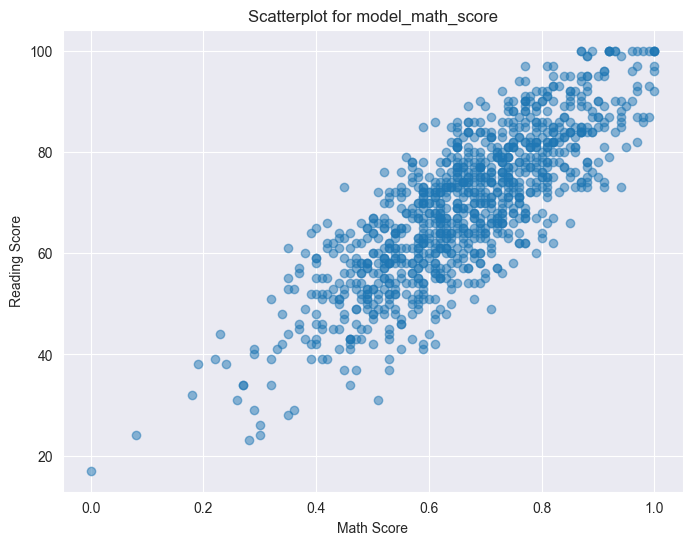

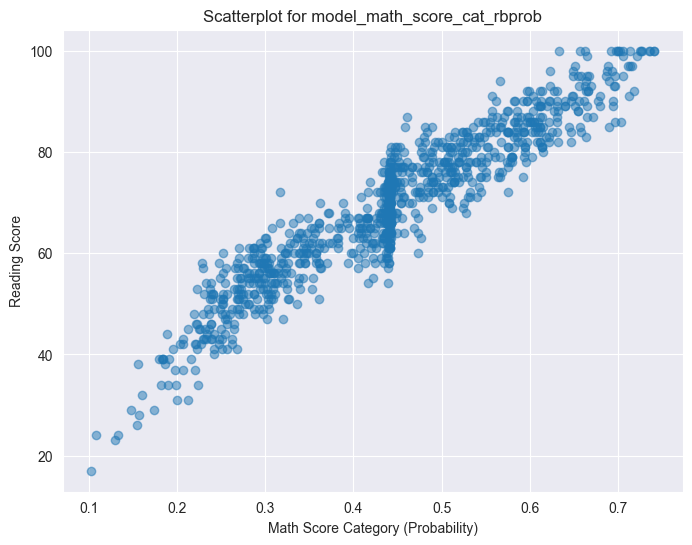

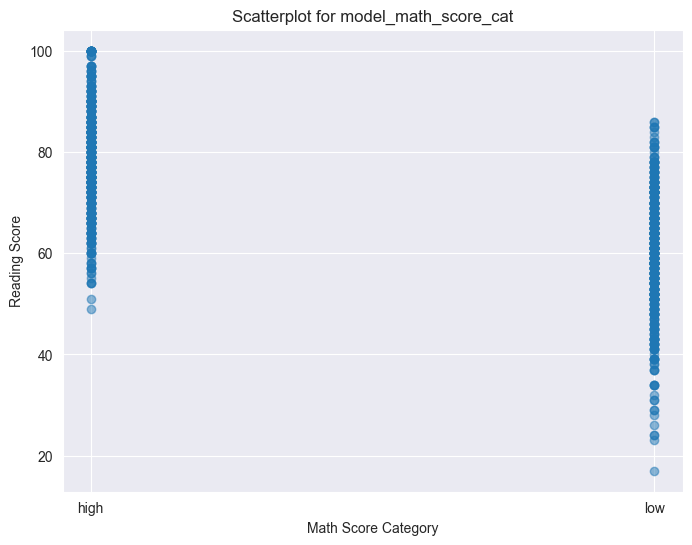

In [121]:
import matplotlib.pyplot as plt

# Scatterplot for model_math_score
plt.figure(figsize=(8, 6))
plt.scatter(scaled_df['math_score'], scaled_df['reading_score'], alpha=0.5)
plt.xlabel('Math Score')
plt.ylabel('Reading Score')
plt.title('Scatterplot for model_math_score')
plt.show()

# Scatterplot for model_math_score_cat_rbprob
plt.figure(figsize=(8, 6))
plt.scatter(scaled_df['math_score_cat_rbprob'], scaled_df['reading_score'], alpha=0.5)
plt.xlabel('Math Score Category (Probability)')
plt.ylabel('Reading Score')
plt.title('Scatterplot for model_math_score_cat_rbprob')
plt.show()

# Scatterplot for model_math_score_cat_rbprob
plt.figure(figsize=(8, 6))
plt.scatter(scaled_df['math_score_cat'], scaled_df['reading_score'], alpha=0.5)
plt.xlabel('Math Score Category')
plt.ylabel('Reading Score')
plt.title('Scatterplot for model_math_score_cat')
plt.show()

In [171]:
csv = 'heart_statlog_cleveland_hungary_final.csv'
my_df = pd.read_csv(csv, index_col=0)
my_df.head()
my_df.dropna(inplace=True)
my_df.reset_index(drop=True, inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sex                  1190 non-null   int64  
 1   chest pain type      1190 non-null   int64  
 2   resting bp s         1190 non-null   int64  
 3   cholesterol          1190 non-null   int64  
 4   fasting blood sugar  1190 non-null   int64  
 5   resting ecg          1190 non-null   int64  
 6   max heart rate       1190 non-null   int64  
 7   exercise angina      1190 non-null   int64  
 8   oldpeak              1190 non-null   float64
 9   ST slope             1190 non-null   int64  
 10  target               1190 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 102.4 KB


Step 1: Checking CUDA availability
CUDA is available! Using GPU

Step 2: Data preprocessing
Target column 'sex' is already binary. Skipping conversion.
Detecting categorical columns...
Column: sex, Data Type: int64
Column: chest pain type, Data Type: int64
Column: resting bp s, Data Type: int64
Column: cholesterol, Data Type: int64
Column: fasting blood sugar, Data Type: int64
Column: resting ecg, Data Type: int64
Column: max heart rate, Data Type: int64
Column: exercise angina, Data Type: int64
Column: oldpeak, Data Type: float64
Column: ST slope, Data Type: int64
Detected categorical columns: []

Step 3: Model training
Custom model specified. Using custom model...


Epoch 11: 100%|██████████| 15/15 [00:00<00:00, 392.26batch/s, loss=0.452]


Early stopping at epoch 11 with F1 score: 0.8747
Best F1: 0.8747


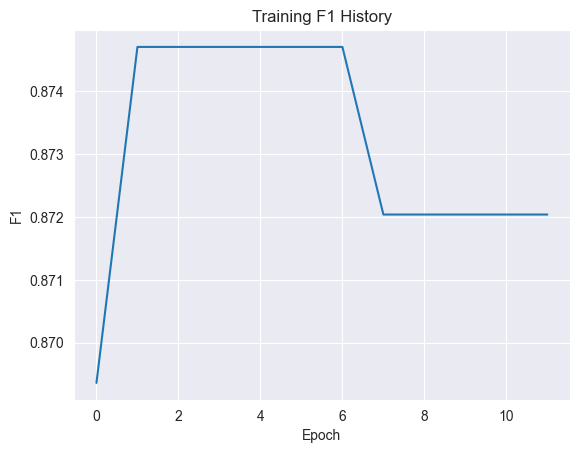


Step 4: Model evaluation
Test Accuracy: 0.7773
Test Precision: 0.7773
Test Recall: 1.0000
Test F1 Score: 0.8747

Step 5: Prediction
Upscaling binary categories to probabilities...
Disclaimer: If F1 score is low, data may not contain sufficient information to create accurate binary-to-probability upscaling.

Step 6: Creating results DataFrame
Labeling predictions...

Step 7: Concatenating results with original data
Creating output data frame...


In [180]:
import importlib
import reverse_binary

importlib.reload(reverse_binary)
from reverse_binary import convert_binary_to_probability

custom_model = nn.Sequential(
    nn.Linear(15, 128),
    nn.ReLU(),
    nn.Linear(128, 96),
    nn.ReLU(),
    nn.Linear(96, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
)

output_df2 = convert_binary_to_probability(
    data=my_df.drop('target', axis=1, inplace=False),
    target_column='sex',
    train_size=.8,
    n_epochs=500,
    batch_size=64,
    threshold=0.5,
    positive_label='1',  # Specify the label to be encoded as 1
    custom_model = custom_model
)

In [182]:
import pandas as pd

# Assuming you have two DataFrames: my_df and output_df
common_cols = list(set(my_df.columns) & set(output_df2.columns))

merged_df = pd.concat([my_df, output_df2.drop(columns=common_cols, inplace=False)], axis=1)
merged_df
# Create a copy to avoid modifying the original DataFrame
scaled_df = merged_df.copy()

scaled_df
from phik import phik_matrix

# Assuming your DataFrame is named 'df'
corr_matrix = phik_matrix(scaled_df)

# Print the correlational table
print(corr_matrix)

# Format the correlational table
formatted_corr_matrix = corr_matrix.style.background_gradient(cmap='coolwarm').format('{:.2f}')

# Display the formatted correlational table
display(formatted_corr_matrix)


interval columns not set, guessing: ['sex', 'chest pain type', 'resting bp s', 'cholesterol', 'fasting blood sugar', 'resting ecg', 'max heart rate', 'exercise angina', 'oldpeak', 'ST slope', 'target', 'sex_rbprob', 'sex_rblab']


C:\Users\calyc\PycharmProjects\sentiment_analysis\.venv\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable sex_rblab for analysis 1. Dropping this column
  warnings.warn(


                          sex  chest pain type  resting bp s  cholesterol  \
sex                  1.000000         0.265845      0.000000     0.303306   
chest pain type      0.265845         1.000000      0.163992     0.199296   
resting bp s         0.000000         0.163992      1.000000     0.054892   
cholesterol          0.303306         0.199296      0.054892     1.000000   
fasting blood sugar  0.163643         0.175179      0.148275     0.399222   
resting ecg          0.039666         0.103138      0.140456     0.313800   
max heart rate       0.270242         0.364764      0.162501     0.357190   
exercise angina      0.294390         0.628558      0.194738     0.141941   
oldpeak              0.167559         0.332240      0.177368     0.187494   
ST slope             0.187078         0.510102      0.197909     0.145051   
target               0.465225         0.735126      0.198358     0.406449   
sex_rbprob           0.236078         0.243121      0.522718     0.806500   

,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target,sex_rbprob
sex,1.00,0.27,0.00,0.30,0.16,0.04,0.27,0.29,0.17,0.19,0.47,0.24
chest pain type,0.27,1.00,0.16,0.20,0.18,0.10,0.36,0.63,0.33,0.51,0.74,0.24
resting bp s,0.00,0.16,1.00,0.05,0.15,0.14,0.16,0.19,0.18,0.20,0.20,0.52
cholesterol,0.30,0.20,0.05,1.00,0.40,0.31,0.36,0.14,0.19,0.15,0.41,0.81
fasting blood sugar,0.16,0.18,0.15,0.40,1.00,0.07,0.11,0.07,0.19,0.23,0.33,0.42
resting ecg,0.04,0.10,0.14,0.31,0.07,1.00,0.26,0.06,0.19,0.06,0.07,0.30
max heart rate,0.27,0.36,0.16,0.36,0.11,0.26,1.00,0.53,0.34,0.37,0.54,0.77
exercise angina,0.29,0.63,0.19,0.14,0.07,0.06,0.53,1.00,0.55,0.61,0.68,0.29
oldpeak,0.17,0.33,0.18,0.19,0.19,0.19,0.34,0.55,1.00,0.54,0.56,0.45
ST slope,0.19,0.51,0.20,0.15,0.23,0.06,0.37,0.61,0.54,1.00,0.78,0.21


In [183]:

from statsmodels.formula.api import ols

# Assuming your dataframe is named 'scaled_df'

# Regression model for 'math_score'
target_sex = ols('target ~ sex', data=scaled_df).fit()
print(target_sex.summary())

# Regression model for 'math_score_cat_rbprob'
target_sex_prob = ols('target ~ sex_rbprob', data=scaled_df).fit()
print(target_sex_prob.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     127.5
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           3.79e-28
Time:                        17:29:22   Log-Likelihood:                -801.11
No. Observations:                1190   AIC:                             1606.
Df Residuals:                    1188   BIC:                             1616.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2491      0.028      8.795      0.0

In [130]:
csv = 'ALL_MFQ30.csv'
my_df = pd.read_csv(csv, index_col=0)
my_df.head()
my_df.dropna(inplace=True)
my_df.reset_index(drop=True, inplace=True)
my_df.info()

my_df = my_df.drop(6546)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11691 entries, 0 to 11690
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   FAIRNESS_AVG   11691 non-null  float64
 1   INGROUP_AVG    11691 non-null  float64
 2   AUTHORITY_AVG  11691 non-null  float64
 3   PURITY_AVG     11691 non-null  float64
 4   Sex            11691 non-null  object 
 5   Country        11691 non-null  object 
dtypes: float64(4), object(2)
memory usage: 548.1+ KB


Step 1: Checking CUDA availability
CUDA is available! Using GPU

Step 2: Data preprocessing
Detecting categorical columns...
Column: FAIRNESS_AVG, Data Type: float64
Column: INGROUP_AVG, Data Type: float64
Column: AUTHORITY_AVG, Data Type: float64
Column: PURITY_AVG, Data Type: float64
Column: Sex, Data Type: int32
Column: Country, Data Type: object
Detected categorical columns: ['Country']

Step 3: Model training
No custom model specified. Using default model...


Epoch 13: 100%|██████████| 147/147 [00:00<00:00, 305.78batch/s, loss=0.556]


Early stopping at epoch 13 with F1 score: 0.5442
Best F1: 0.5442


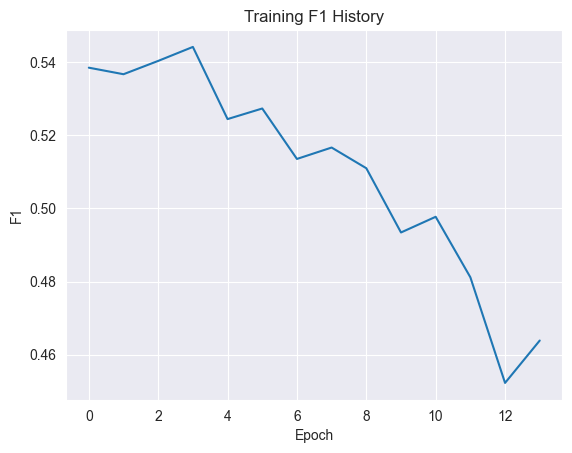


Step 4: Model evaluation
Test Accuracy: 0.5205
Test Precision: 0.4246
Test Recall: 0.8170
Test F1 Score: 0.5588

Step 5: Prediction
Upscaling binary categories to probabilities...
Disclaimer: If F1 score is low, data may not contain sufficient information to create accurate binary-to-probability upscaling.

Step 6: Creating results DataFrame
Labeling predictions...

Step 7: Concatenating results with original data
Creating output data frame...


In [169]:
import importlib
import reverse_binary

importlib.reload(reverse_binary)
from reverse_binary import convert_binary_to_probability

custom_model = nn.Sequential(
    nn.Linear(15, 128),
    nn.ReLU(),
    nn.Linear(128, 96),
    nn.ReLU(),
    nn.Linear(96, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
)

output_df2 = convert_binary_to_probability(
    data=my_df,
    target_column='Sex',
    train_size=.8,
    n_epochs=500,
    batch_size=64,
    threshold=0.5,
    positive_label='1',  # Specify the label to be encoded as 1
    custom_model = None
)

In [132]:
output_df2

,FAIRNESS_AVG,INGROUP_AVG,AUTHORITY_AVG,PURITY_AVG,Sex,Country,Sex_rbprob,Sex_rblab
0,0.000000,0.000000,0.000000,0.000000,1,Australia,0.683774,1.0
1,4.166667,3.000000,3.833333,2.833333,0,Australia,0.290928,0.0
2,4.500000,1.333333,1.166667,1.000000,1,Australia,0.355360,0.0
3,3.500000,3.333333,3.000000,1.500000,0,Australia,0.388619,0.0
4,3.666667,3.333333,3.333333,1.833333,0,Australia,0.385828,0.0
...,...,...,...,...,...,...,...,...
11687,4.833333,2.166667,2.500000,1.000000,1,US,0.543213,1.0
11688,2.833333,1.000000,1.666667,0.833333,0,US,0.517049,1.0
11689,3.500000,3.500000,3.833333,4.666667,0,US,0.455618,0.0
11690,4.000000,1.500000,2.333333,0.333333,1,US,NaN,NaN
